**INTRODUCTION**

Dans ce projet, nous allons exploiter les avis postés par les utilisateurs sur Google Play, afin de découvrir s'ils peuvent nous aider à déterminer les attentes des consommateurs pour une catégorie d'applications donnée. En considérant que la qualité d'une application est quantifiée par la note attribuée par l'utilisateur en compagnie de son avis, nous avons tenté de déterminer quels termes présents dans les avis expliquent une note d'utilisateur élevée et quels termes expliquent à l'opposé une note d'utilisateur faible.

<ins>Problématique<ins/>

**Quelles sont les qualités attendues par les utilisateurs et les défauts à éviter pour une application d'une catégorie donnée ?**

Plusieurs dimensions de ce projet nous ont séduits et nous ont conduits à le choisir :
 - le travail sur la récupération de donnée, d'autant plus intéressant que le site Google Play présente certains pare-feux et obstacles nécessitant d'aller un peu plus loin que BeautifulSoup
 - l'aspect Machine Learning qui nous a conduit à réfléchir pour la première fois à des questions liées au choix du modèle, des paramètres et des critères d'évaluation de la prédiction
 - l'aspect NLP qui permet d'obtenir des résultats parlants, des visuels sympathiques et surtout de s'initier à des méthodes de prédiction porteuses

Nous avons tout d'abord récupéré les données de commentaires et de notes d'utilisateurs sur le site de Google Play Applications. Nous avons ensuite proposé quelques statistiques descriptives permettant de se faire une idée du contenu de la base, comme la note moyenne et la taille des commentaires selon les notes.
Après nettoyage et notamment lemmatisation des termes des commentaires, nous avons appliqué un algorithme de classification pour déterminer la note d'utilisateur à partir des mots contenus dans l'avis correspondant. Les résultats du modèle prennent la forme d'une liste de mots ordonnée par connotation vis-à-vis de l'objectif "donner une note supérieure à 4/5". Les vingt premier mots sont ceux qui expliquent le plus une note élevée, et inversement les vingt dernier mots sont ceux expliquant une note faible. Enfin, nous avons analysé ces termes connotés positivement et négativement et avons réalisé une comparaison des résultats entre les différentes catégories d'applications.

**TABLE DES MATIERES**

- Préliminaires
- Récupération des données
- Nettoyage
- Statistiques descriptives
- Modèle
- Analyse des résultats
- Conclusion

**PRELIMINAIRES**

Le projet a requis l'utilisation d'un certain nombre de packages :
 - urllib, bs4, et selenium pour la partie webscraping
 - spacy et fr_core_news_sm pour la partie nlp
 - tkinter pour l'interface utilisateur de sélection de la catégorie à exploiter
 - scikit-learn pour la partie modélisation
 - matplotlib, seaborn et wordcloud pour les visualisations

In [1]:
import urllib, json, requests
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import fr_core_news_sm 
nlp = fr_core_news_sm.load()
from spacy_langdetect import LanguageDetector
nlp.add_pipe(LanguageDetector(), name='language_detector', last=True)
nlp.max_length = 1600000

import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.common.exceptions import StaleElementReferenceException
import time

import tkinter as tk
from tkinter import *
from tkinter import ttk

from wordcloud import WordCloud

La fonction ci-après permet à l'utilisateur de sélectionner la catégorie d'applications avec laquelle il souhaite travailler.

Soit la base correspondante a déjà été générée par nos soins et fera partie de la liste categ_list_done : il suffira alors d'importer la base présente au format csv dans "Avis scrappés"

Soit la base correspondante n'a pas déjà été générée et il faudra alors lancer le webscrapping avant de pouvoir travailler sur les données de cette catégorie.

In [40]:
#Fonction permettant d'afficher des menus de selection

def selector(searched_thing, list_of_poss, multip_selec=False):
    root = tk.Tk()                                     #La racine correspond à la fenêtre vide, que l'on crée en instanciant la classe
    root.geometry('300x200')                           #On détermine les dimensions de la fenêtre

    text = 'Please select a ' + searched_thing         #Il s'agit du texte que verra l'utilisateur
    labelChoix = tk.Label(root, text = text)           #On assigne ce texte à notre racine
    labelChoix.pack()                                  #LabelChoix devient un noeud

    if multip_selec == False:                          #C'est le paramètre par défaut : on ne souhaite pas que l'utilisateur puisse faire plusieurs choix
        listeCombo = ttk.Combobox(root, values=list_of_poss)  #On crée alors une liste déroulante depuis notre racine avec les valeurs dans la liste entrée en argument
        listeCombo.pack()                              #ListeCombo devient un noeud

        chosen = StringVar()                           #On crée un objet StringVar qui contiendra le choix de l'utilisateur

        def action(event):                             #Lorsque l'utilisateur clique sur la catégorie souhaitée, cette fonction est exécutée
            item = listeCombo.get()                    #On récupère ce sur quoi a cliqué l'utilisateur
            chosen.set(item)                           #On assigne cette valeur à notre StringVar

        listeCombo.bind("<<ComboboxSelected>>", action)  #On associe l'action définie à notre objet donnant une liste déroulante
        root.mainloop()                                #On affiche la liste déroulante

        return chosen                                   #On retourne la StringVar
    
    else:                                                #Si on veut permettre une selection multiple
        chosen = []                                      #Dans ce cas on retournera la liste des catégories sélectionnées
        def CurSelet(evt):                               #On définit l'action
            nonlocal chosen                              #Il faut pouvoir modifier chosen dans la fonction
            values = [mylistbox.get(idx) for idx in mylistbox.curselection()]  #on récupère la liste des catégories sélectionnées
            chosen = values                              #On l'assigne à chosen

        mylistbox=Listbox(root, selectmode='multiple')    #On crée un objet Liste (non déroulantes) en permettant la séléction multiple
        mylistbox.bind('<<ListboxSelect>>',CurSelet)      #On l'associe à notre action
        mylistbox.place(x=30,y=30)                        #On définit sa position dans la fenêtre root

        for items in list_of_poss:                        
            mylistbox.insert(END,items)                   #On définit les catégories devant constituer notre liste : toutes celles dans list_of_poss

        root.mainloop()                                   #On affiche la liste

        return chosen                                     #On retourne la liste des catégories selectionnées

#On définit ce qui a déjà ou non été scrappé. Note : si on scrappe une nouvelle catégorie, elle sera automatiquement ajoutée à categ_list_done. Mais il 
#faudra aussi modifier ces listes manuellement pour que le programme retienne cette modification lors des prochains démarrages.
categ_list_done = ['FINANCE', 'SPORTS', 'ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'WEATHER', 'EDUCATION', 'GAME_ACTION', 'DATING', 'SOCIAL', 'GAME_TRIVIA', 'PRODUCTIVITY', 'GAME_ADVENTURE']
categ_list_not_done = sorted(['NEWS_AND_MAGAZINES', 'COMICS', 'BEAUTY', 'COMMUNICATION', 'FOOD_AND_DRINK', 'LIBRARIES_AND_DEMO', 'ENTERTAINMENT', 'HOUSE_AND_HOME', 'VIDEO_PLAYERS', 'BOOKS_AND_REFERENCE', 'MUSIC_AND_AUDIO', 'MEDICAL', 'TOOLS', 'PARENTING', 'PHOTOGRAPHY', 'MAPS_AND_NAVIGATION', 'BUSINESS', 'HEALTH_AND_FITNESS', 'SHOPPING', 'EVENTS', 'LIFESTYLE', 'TRAVEL_AND_LOCAL', 'ANDROID_WEAR', 'GAME', 'FAMILY', 'GAME_ARCADE', 'GAME_CARD', 'GAME_CASINO', 'GAME_EDUCATIONAL', 'GAME_CASUAL', 'GAME_RACING', 'GAME_ROLE_PLAYING', 'GAME_BOARD', 'GAME_WORD', 'GAME_MUSIC', 'GAME_PUZZLE', 'GAME_SIMULATION', 'GAME_SPORTS', 'GAME_STRATEGY'])

**RECUPERATIONS DES DONNEES**

<ins> Importer des données déjà scrappées <ins/>

Partie à faire tourner uniquement pour récupérer les avis d'une des catégorie déjà scrappée

In [3]:
#CHOISIR UNE CATEGORIE 
#attention, le menu déroulant de choix s'ouvre dans une nouvelle fenêtre

category = selector('category', categ_list_done)    #On affiche le menu déroulant

In [4]:
#Récupération du csv correspondant

cat = category.get()                                #On récupère le nom de la catégorie
file = 'Avis scrappés/'+cat+'.csv'                  #On récupère le nom du csv correspondant
reviews_df = pd.read_csv(file)                      #On importe ce csv dans reviews_df

<ins> Scrapper de nouvelles données <ins/>

Partie à faire tourner uniquement pour récupérer les avis d'une catégorie non encore scrappée

In [51]:
#CHOISIR UNE CATEGORIE NON SCRAPPEE

category = selector('category', categ_list_not_done)  #On affiche le menu déroulant

cat = category.get()                                  #On récupère le nom de la catégorie
categ_list_done += [cat]                              #On ajoute cette catégorie à la liste des catégories scrappées
categ_list_not_done.remove(cat)                       #On la retire de celle des catégories non scrappées

In [52]:
#CHOIX DU NAVIGATEUR

list_browser = ['Safari', 'Chrome', 'Edge', 'Firefox']
browser = selector('browser', list_browser)          #On demande à l'utilisateur de choisir un navigateur (pour Selenium)


In [53]:
# La fonction suivante vise à attribuer à un navigateur (paramètre de la fonction from_cat_to_list_of_apps), le
# driver correspondant. Le driver permettra à la fonction from_cat_to_list_of_apps d'utiliser selenium.

def set_browser(navigateur):
    if navigateur == 'Safari':
        browser = webdriver.Safari()
    elif navigateur == 'Chrome':
        browser = webdriver.Chrome('chromedriver.exe')
    elif navigateur == 'Edge':
        browser = webdriver.Edge()
    elif navigateur == 'Firefox':
        browser = webdriver.Firefox()
    else:
        return 'You must use one of these four browsers : Chrome, Safari, Firefox, Edge'
    return browser

Les données sur lesquelles nous travaillons dans ce projet proviennent des avis d'utilisateurs d'applications, disponibles sur le site Google Play Applications. Celui-ci offre la possibilité de choisir une catégorie d'applications, comme Jeux d'aventure, ou encore Sports. Notre récupération et analyse des données se fait ainsi par catégorie.

Certaines catégories contiennent beaucoup d'applications. Ainsi, les bases de donnée prises séparément par catégorie sont volumineuses (2MB), et surtout l'opération de scraping permettant d'obtenir ces bases recquiert un temps important, ce qui justifie de ne pas lancer le scraping sur toutes les catégories à la fois.

De plus, notre analyse porte par la suite sur une catégorie à la fois, car nous cherchons à trouver les termes positifs et négatifs pour une catégorie d'application donnée. Il n'est dons pas utile, sachant le temps de l'opération, d'obtenir une base comprenant les données de toutes les catégories, si nous la divisons par la suite.

Notre opération de scraping utilise principalement le module BeautifulSoup et se divise en deux fonctions :
 - from_cat_to_list_of_apps
 - from_cat_to_db

1) from_cat_to_list_of_apps permet d'obtenir une liste d'applications disponibles sur Google Play correspondant à la catégorie indiquée en entrée. Notre première version de la fonction de scraping n'intégrait pas cette fonction et se contentait de parcourir les applications visibles sur la page d'accueil de la catégorie. L'échantillon que l'on obtenait était sensiblement plus petit que celui que l'on obtient à présent avec cette fonction : la première base extraite pour la catégorie Finance comprenait environ 400 lignes, contre plus de 3000 actuellement. Pour obtenir davantage de lignes, il nous fallait soit récupérer davantage d'avis par applications, soit récupérer les avis d'un nombre plus grand d'applications. Après de nombreux essais et recherches, il nous est apparu que la première option est particulièrement ardue. En effet, lorsque l'on ouvre une page Google Play correspondant à une application, seuls certains commentaires s'affichent. Pour en afficher plus, il faut faire dérouler la page. Cependant, l'utilisation de Selenium ne permet pas de résoudre ce problème en se déplaçant simplement sur la page, puisque la page internet ne charge que quarante avis à l'ouverture. Après enquête au moyen du Web Inspector, nous avons compris que la page envoie une requête XHR à un serveur au moment où l'on descend afin de charger davantage de commentaires. La source de ce chargement est malheureusement indisponible, et la technique de récupération de ce type d'information est apparue, après recherches, très ambitieuse à notre niveau.
Nous nous sommes donc concentrés sur la deuxième option consistant à récupérer les commentaires pour davantage d'applications, et donc à parcourir un nombre plus élevé de pages d'application. Cette fonction from_cat_to_list_of_apps génère une liste comportant l'url de nombreuses applications pour la catégorie donnée. Pour la construire, nous avons utiliser Selenium, qui cette fois-ci était un outil suffisant pour parcourir la page et obtenir une page html complète répondant à notre besoin.

2) from_cat_to_db génère une bas de donnée avec quatre colonnes : le nom de l'application, la note google de cette appli, les avis de l'application scrappés, et les notes données par les auteurs des avis. Pour aller chercher les commentaires, la fonction parcourt la liste récupérée au moyen de la fonction précédente from_cat_to_list_of_apps. L'url de chaque application permet de se rendre sur la page de commentaires correspondante, et de récupérer jusqu'à quarante d'entre eux. On en profite pour ne récupérer que les avis comportant des termes français.

In [54]:
# Fonction générant la liste des applications de la catégorie que l'on souhaite. Elle prend en entrée une catégorie
# d'applications présente sur le site google_play, et le navigateur de l'utilisateur servant à effectuer des requêtes
# avec selenium

def from_cat_to_list_of_apps(category, navigateur='Chrome'):
    url = 'https://play.google.com/store/apps/category/' + category + '?hl=fr'

    resp = urllib.request.urlopen(url).read()
    soup = BeautifulSoup(resp, "html.parser")

    id_apps = []
    name_apps = []
    google_score = []

    # On récupère les liens vers les clusters d'app proposés par google (eg : recommandé, app premium, jeu hors connexion)
    app_clusters = soup.findAll('div', {'class':'xwY9Zc'})

    browser = set_browser(navigateur)

    # On ouvre la page regroupant toutes les applis pour chacun des clusters avec Selenium
    for i in range(len(app_clusters)):
        app_cluster = app_clusters[i]
        lien_app_cluster = app_cluster.find('a').get('href')[31:]
        url_cluster = 'https://play.google.com/store/apps/collection/cluster?hl=fr&' + lien_app_cluster

        browser.get(url_cluster)

        # On parcours toute la page avec Selenium pour que toutes les éléments html liés aux applis soient chargés,
        # pas seulement les éléments html correspondant aux applications visibles en début de page
        last_height = 0
        while True:
            # Scroll down
            browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")

            # Pause, le temps que la page se charge après chaque descente
            time.sleep(0.5)

            # Calcul de la distance parcourue
            new_height = browser.execute_script("return document.body.scrollHeight")
            # Si la distance calculée est égale à celle calculée durant la dernière boucle, nous sommes en bout de page !
            if new_height == last_height:
                break
            last_height = new_height

        # Nous pouvons commencer le sraping à proprement parler avec BeautifulSoup
        page_cluster = BeautifulSoup(browser.page_source, "html.parser")

        # Récupération des id de chaque appli servant à ouvrir leur page de commentaire, du nom de l'appli et de sa note Google

        list_of_id = page_cluster.findAll('div',{'class':'wXUyZd'})
        list_of_name = page_cluster.findAll('div',{'class':'WsMG1c nnK0zc'})
        list_of_score = page_cluster.findAll('div',{'class':'pf5lIe'})

        for i in range(len(list_of_score)):
            # Attention : certaines applis n'ont pas de notes donc on élimine cette éventualité
            if page_cluster.findAll('div',{'class':'k6AFYd'})[i].find('div',{'class':'pf5lIe'}) != None:
                app_id = list_of_id[i].find('a').get('href')[23:]

                # On vérifie bien que l'app dont on récupère les informations n'est pas déjà dans la liste
                # Une même application peut en effet faire partie de plusieurs clusters
                if (app_id not in id_apps):
                    name = list_of_name[i].get("title")
                    app_score = list_of_score[i].find('div').get('aria-label')[:3]
                    id_apps.append(app_id)
                    name_apps.append(name)
                    google_score.append(app_score)

    # On quitte le browser contrôlé avec Selenium
    browser.quit()
    
    return id_apps, name_apps, google_score

In [55]:
# Fonction prenant en input une catégorie d'application et renvoyant un dataframe regroupant un certain nombre
# d'applications de cette catégorie, extraite à partir de la fonction from_cat_to_list_of_apps. Pour chaque appli,
# nous récupérons la note google de cette application, des commentaires dans une limite de quarante par 
# application, et les notes d'utilisateurs associées à ces avis.

def from_cat_to_db(category, navigateur):
    #on utilise beautifulSoup pour lire une page googleplay correspondant à la catégorie annoncée
    url_gp = 'https://play.google.com/store/apps/category/' + category
    request_gp = urllib.request.urlopen(url_gp).read()
    page = BeautifulSoup(request_gp)
    
    # on récupère pour chaque application de la page son nom,son id permettant d'afficher les commentaires associés
    # et sa note attribuée par Google
    id_apps, name_apps, google_score = from_cat_to_list_of_apps(category, navigateur)
    
    # on crée un ensemble de liste servant à stocker le nom d'une application, sa note globale, les commentaires ainsi que les notes disponibles sur cette appli
    review_list = [[],[],[],[]]
    
    number_of_apps = len(id_apps)

    for elem in range(number_of_apps):

        URL='https://play.google.com/store/apps/details?id='+id_apps[elem] +'&hl=fr&showAllReviews=true'
        USER_AGENT = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:65.0) Gecko/20100101 Firefox/65.0"
        headers = {"user-agent": USER_AGENT}
        resp = requests.get(URL, headers=headers)
        soup = BeautifulSoup(resp.content, "html.parser")

        # Si l'on affiche soup.prettify, on peut voir que tous les commentaires sont situés au sein d'une balise
        # <script nonce:"...">. Mais nonce change à chaque fois que l'on fait une requete. Donc, en utilisant script
        # pour le find_all, on trouve beaucoup de résultats. POur trouver quel élément de la liste contient les 
        # avis, on remarque qu'ils possèdent 'gp' avant le nom de l'utilisateur

        zone_closest_delimiter = soup.find_all('script', text=True)
        for content in zone_closest_delimiter:
            if ('gp:' in content.string):
                brut_avis = content

        #Tous les avis sont précédés par ',null,"' et la note est le chiffre juste avant. On scinde donc en segments selon ce délimiteur


        # On remarque que les commentaires sont les seuls à ne pas posséder de liens et pour la note il suffira de 
        # selectionner le dernier élément du segment précédent. Attention : le tout premier élément fait exception

        list_of_segments = str(brut_avis.string).split(',null,"')[1:]
        list_of_comments_brut = []
        list_of_notes = []
        for k in range(len(list_of_segments)):
            if ('https://play-lh.googleusercontent' not in  list_of_segments[k]):
                list_of_comments_brut += [list_of_segments[k]]
                list_of_notes += [list_of_segments[k-1][-1]]


        #Reste alors à nettoyer les commentaires bruts pour ne garder que ce qu'a écrit l'utilisateur. A chaque fois, on trouve à la fin de l'avis ' ",[ '
        #On ne garde également que les commentaires en français
        french_words = (' ce ', ' ces ',' le ', ' la ', ' les ', ' un ', ' une ', ' je ', ' tu ', ' il ', " j' ", ' nous ', ' vous ', ' ils ', ' elle ', ' elles ', ' du ', ' des ', ' et ', ' même ')
        list_of_comment_clean = []
        for k in range(len(list_of_comments_brut)):
            review = list_of_comments_brut[k].split('",[')[0]
            if any(word in review.lower() for word in french_words):
                list_of_comment_clean += [review]

        #On construit les colomnes de notre future dataframe
        for rev in range(len(list_of_comment_clean)):    
            review_list[0].append(name_apps[elem])
            review_list[1].append(google_score[elem])
            review_list[2].append(list_of_comment_clean[rev])
            review_list[3].append(list_of_notes[rev])
    #On récupère notre dataframe
    review_dict = {'app' : review_list[0], 'google_score' : review_list[1], 'reviews' : review_list[2], 'user_grade' : review_list[3]}
    db_reviews = pd.DataFrame.from_dict(review_dict)
    
    return db_reviews

In [56]:
# EXECUTER LE WEBSCRAPPING

cat = category.get()                     
browser = browser.get()
reviews_df = from_cat_to_db(cat, browser)  #On fait tourner nos fontions de webscrapping avec la catégorie et le navigateurs sélectionnés par l'utilisateur 

Exportons à présente les données récupérées par notre webscrapping dans notre dossier "Avis scrappés". Cela nous évitera de devoir les récupérer à nouveau

In [138]:
# EXPORTER LES AVIS SCRAPPES
filename = 'Avis scrappés/'+cat+'.csv'
reviews_df.to_csv(filename)

**NETTOYAGE**

La base de donnée scrappée contient quelques déchets, notamment des lignes sans commentaires (qui comportent une erreur commençant par 'https://ogs.google'). De plus, la note d'utilisateur et la note google ont été récupérées sous format string. Il convient donc de les convertir en nombres ; en int pour la note d'utilisateur qui est un entier de 1 à 5 ; en float pour la note google qui est une note comprenant une décimale séparée de l'entier par une virgule, d'où l'application d'une fonction convert_frenchscore.

In [5]:
def convert_frenchscore(string):
    return float(f"{string[0]}.{string[-1]}")


reviews_df = reviews_df[~reviews_df['reviews'].str.contains('https://ogs.google')]    #Supprimer les lignes dont les avis contiennent https://ogs.google 
reviews_df = reviews_df.reset_index()
reviews_df = reviews_df.drop(columns='index')
reviews_df.user_grade = reviews_df.user_grade.replace('\r\n', np.nan)                  #remplacer les notes affichant '\r\n' par une note absente 
reviews_df.user_grade = reviews_df.user_grade.replace('\n', np.nan)                    #remplacer les notes affichant '\n' par une note absente
reviews_df = reviews_df.dropna(subset=['user_grade'])                                  #Supprimer les lignes où la note est absente

# On met les notes d'utilisateurs au format numérique pour pouvoir les intégrer dans des graphiques
reviews_df['user_grade'] = reviews_df['user_grade'].apply(int, 1)
reviews_df['google_score'] = reviews_df['google_score'].apply(convert_frenchscore, 1)

**STATISTIQUES DESCRIPTIVES**

<ins> Brève description de la base <ins/>

On débute par un premier aperçu de la base et de ses caractéristiques.

En premier lieu, on cherche à savoir quels sont les termes revenant le plus dans notre corpus de commentaires. Un wordcloud, nettoyé des mots communs, permet ainsi de voir rapidement quels mots comptent le plus en terme de fréquence dans les commentaires correspondant à la catégorie d'application choisie.

Text(0.5, 1.0, 'Nuage affichant les 50 mots les plus fréquents dans les commentaires de la catégorie WEATHER')

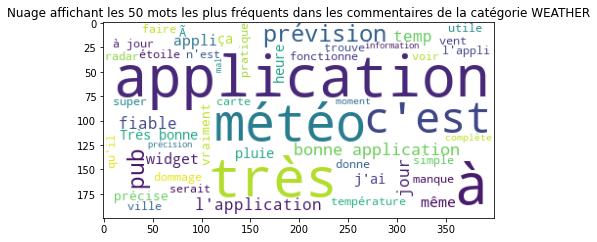

In [6]:
# on récupère le corpus de commentaires dans une string unique
text = "".join(reviews_df['reviews'])

# on utilise une liste de stop words constituée de termes français très courants comme les articles, liste
# téléchargée depuis le site countwordsfree
stop_words = open("stop_words_french.txt").read().split('\n')

# on génère le wordcloud
word_cloud = WordCloud(stopwords = stop_words, background_color = 'white', max_words = 50).generate(text)
plt.figure(figsize=(7,8))
plt.imshow(word_cloud)
plt.title(f"Nuage affichant les 50 mots les plus fréquents dans les commentaires de la catégorie {cat}")

Comme on peut le voir ci-dessus, certains mots étaient attendus, car faisant partie du champ lexical de l'application, ou encore de la catégorie concernée. Ainsi, certains termes comme "application" reviennent pour chaque catégorie, et d'autres comme "profil" et "rencontre" pour Dating, sont propres au secteur de l'application. On peut déjà voir que des mots clairement positifs ("bien", "gratuit", "sympa") et clairement négatifs ("pub", "impossible", "problème") apparaissent.
Notons également que nous ne parvenons pas, dans ce premier jet, à éliminer tous les mots inutiles.

Ensuite, on souhaite connaître le nombre moyen de commentaires récupérés par application. Il est important de rappeler que notre méthode de scrapping limite le nombre maximum de commentaire pouvant être obtenu par application à 40.  S'il est significativement inférieur à 40, cela veut dire qu'un nombre important d'applications de la catégorie offraient très peu de commentaires en français.

In [7]:
# Nombre moyen de commentaires par applications
reviews_df.groupby(by='app')['user_grade'].describe()['count'].mean()

22.55140186915888

Enfin, voici une comparaison entre d'une part, la note moyenne des applications de notre catégorie calculée à partir des notes d'utilisateur que l'on a récupérées avec les commentaires, et d'autre part, la note moyenne des applications de notre catégories calculée à partir des notes google (colonne 'google_score') des applications de la catégorie.
On affiche également les écarts-types correspondant.

In [8]:
# Premier calcul : moyenne des notes moyennes par application, la note moyenne de l'application correspondant à la
# moyenne des notes d'utilisateurs récoltées.
mean_user_grade = reviews_df.groupby(by='app')['user_grade'].describe()['mean'].mean()
std_user_grade = reviews_df.groupby(by='app')['user_grade'].describe()['mean'].std()
print("Moyenne des notes d'utilisateur : ", mean_user_grade, "(ecart-type : ", std_user_grade, ")")

# Deuxième calcul : moyenne des notes google de chaque application
mean_g_grade = reviews_df['google_score'].mean()
std_g_grade = reviews_df['google_score'].std()
print("Note Google moyenne :             ", mean_g_grade, "(ecart-type : ", std_g_grade, ")")

Moyenne des notes d'utilisateur :  3.95101320487878 (ecart-type :  0.8513486975676055 )
Note Google moyenne :              4.505263157894719 (ecart-type :  0.22163567087254984 )


On remarquera que la première moyenne à partir des notes d'utilisateur est différente de la note de l'application attribuée par Google. Une première raison l'expliquant : leur échantillon est plus vaste que le notre. D'autre part, Google fonde sa note sur sur les avis les plus récents, tandis que certains commentaires de notre échantillon peuvent être assez anciens, ceux-ci ayant été récoltés lorsque le filtre "les plus pertinents" et non "les plus récents" était activé.

<ins>Longueur des commentaires</ins>

On souhaite à présent se faire une première idée des facteurs différenciant les commentaires associés à de bonnes notes et les commentaires associés à de mauvaises notes.
Une première étape concerne l'analyse de la taille des commentaires selon les notes. Les utilisateurs peu satisfaits expliquent-ils leur mécontentement ou se content-ils de laisser des remarques négatives pas vengeance ?

In [9]:
# fonction comptant le nombre de mots dans un corpus de texte
def count_words(review):
    list_of_words = review.split(' ')
    return len(list_of_words)

In [10]:
# On ajoute une colonne length_reviews correspondant à la taille des avis, celle-ci étant cacluler en nombre de mots

reviews_df['length_review'] = reviews_df['reviews'].apply(count_words, 1)

             count       mean        std  min   25%   50%   75%    max
user_grade                                                            
1            245.0  27.563265  20.170611  3.0  11.0  22.0  38.0   93.0
2            148.0  30.439189  21.054586  3.0  14.0  25.0  42.0   90.0
3            175.0  25.194286  20.306473  3.0   9.5  18.0  35.0   86.0
4            517.0  23.189555  18.768759  3.0  10.0  17.0  31.0  110.0
5           1328.0  19.539910  15.450333  3.0   9.0  15.0  25.0   99.0


Text(0.5, 0, 'Note')

<Figure size 432x288 with 0 Axes>

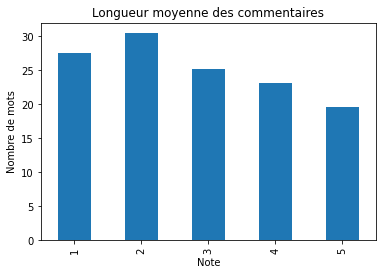

In [14]:
info_length_review = reviews_df.groupby(by='user_grade')['length_review'].describe()
print(info_length_review)
plt.figure()
info_length_review.reset_index().plot('user_grade', 'mean', kind='bar', legend=None)
plt.title('Longueur moyenne des commentaires')
plt.ylabel('Nombre de mots')
plt.xlabel('Note')

On voit ici que les utilisateurs donnant une note faible ont tendance à écrire des commentaires plus longs que ceux donnant une note élevée. Ce constat concerne la moyenne des mots par note. Tentons de préciser l'analyse en représentant les distributions de la longueur des commentaires pour chaque note, et de vérifier que les distributions des notes basses sont davantage étalées à droite que celles des notes élevées.

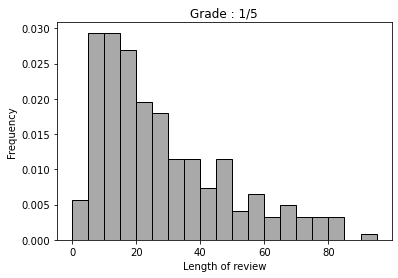

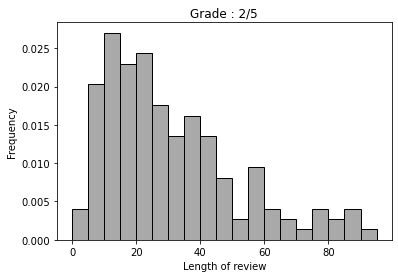

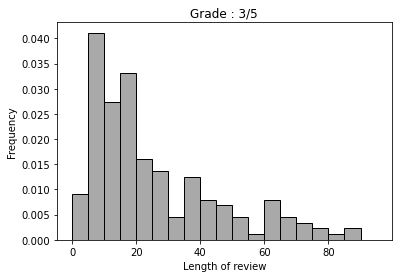

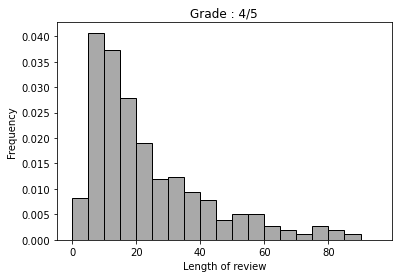

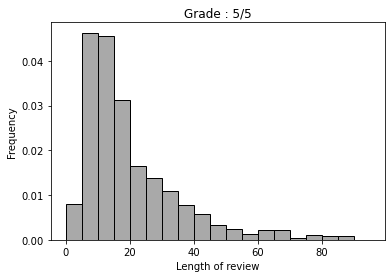

In [15]:
# Le tail_weight mesure l'étalement à droite de la distribution de la longueur des commentaires
def tail_weight(dist):
    tau = np.quantile(dist, 0.75) - (np.quantile(dist, 0.1) + np.quantile(dist, 0.9))/2
    return tau

tail_thickness = []

# pour chaque note, on récupère la distribution de la longueur des commentaires, la mesure tail_weight de celle-ci,
# et on trace le graphe de cette distribution
for grade in range(1, 6):
    length_rev_dist = reviews_df[reviews_df['user_grade'] == grade]['length_review']
    tau = tail_weight(length_rev_dist)
    tail_thickness.append(tau)
    plt.figure()
    plt.hist(length_rev_dist, bins=range(0,100,5), density=True, color='darkgray', edgecolor='black')
    plt.title(f'Grade : {grade}/5')
    plt.xlabel('Length of review')
    plt.ylabel('Frequency')

Text(0.5, 0, 'Note attribuée')

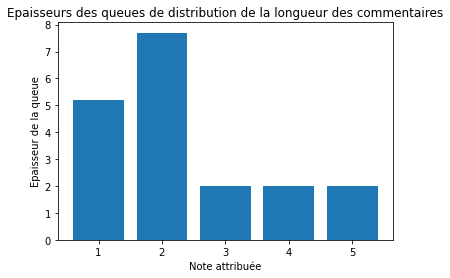

In [16]:
# On affiche ici le tail_weight des différentes notes
plt.bar(range(1,6), tail_thickness)
plt.title("Epaisseurs des queues de distribution de la longueur des commentaires")
plt.ylabel('Epaisseur de la queue')
plt.xlabel('Note attribuée')

L'observation pour chacune des notes de la distribution de la longueur des commentaires permet bien de préciser l'analyse. On voit que les mécontents écrivent des commentaires de différentes tailles, y compris des commentaires assez longs, tandis que la proportion des retours brefs chez les utilisateurs satisfaits est bien plus importante. Cette tendance est plus ou moins marquée selon la catégorie d'application étudiée mais se retrouve partout.

<ins>Quel est la taille de notre échantillon en terme de radical sémantique ?<ins/>

In [17]:
# Première estimation du nombre de mots
sum(reviews_df['length_review'])
# Il y a en fait beaucoup de chaînes de caractères ne correspondant pas à des mots français(mots étrangers,
# fautes de frappes, chiffres, etc)

53605

L'estimation grossière réalisée ci-dessus surestime largement la taille réelle de l'échantillon sur lequel nous allons concentrer notre analyse.

En effet, la modélisation portera sur un échantillon réduit, en terme de nombre de mots, par rapport au corpus de commentaires initial. Comme nous l'avons vu avec le premier wordcloud, de nombreux mots ne sont pas pertinents car peu informatifs (articles, pronoms). Nous allons donc nous limiter aux adjectifs, verbes et noms. De plus, notre analyse est rendue plus précise par le fait que nous lemmatisons, c'est-à-dire que nous confondons en une seule information des mots différents ayant le même radical sémantique. Enfin, nous avons jugé important de nous rendre compte de la diminution du corpus découlant du simple fait que des mots apparaissent plus d'une fois dans le corpus de départ.

La partie qui suit donne un aperçu de l'impact chiffré de ces nettoyages.

In [18]:
# On utilise spacy pour filtrer les mots selon les critères qui nous intéressent

story = ' '.join(reviews_df['reviews'])
doc = nlp(story)

tokens = []
for sent in doc.sents:
    if sent._.language['language']=='fr':
        for token in sent:
            if token.is_alpha:
                tokens.append(token)

# On récupère les mots français
words = [token.text for token in tokens]
# Puis la liste des mots sans doublons
diff_words = list(set(words))
# On va s'intéresser principalement aux adjectifs, verbes et noms dans notre analyse donc il est utile de compter
# les mots rentrant dans ces catégories
list_of_accepted_types = ['ADJ', 'VERB', 'NOUN']
words2 = [token.text for token in tokens if (token.is_alpha and (token.pos_ in list_of_accepted_types))]
words_avn = list(set(words2))
# Enfin, on va également lemmatiser, donc regardons comment cela impacte le nombre de mots
words3 = [token.lemma_ for token in tokens if (token.is_alpha and (token.pos_ in list_of_accepted_types))]
words_avn_lem = list(set(words3))

<Figure size 432x288 with 0 Axes>

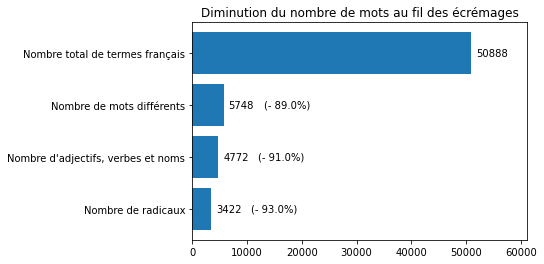

In [19]:
# On rentre les longueurs dans une liste, puis les impacts des écrèmages successifs en pourcentage par rapport au
# premier nombre
word_counts = [len(words), len(diff_words), len(words_avn), len(words_avn_lem)]
per_change = [f"(- {round(100*(word_counts[0] - word_counts[i])/word_counts[0],0)}%)" for i in range(len(word_counts))]
per_change[0] = ""
labels = ['Nombre total de termes français', 'Nombre de mots différents',"Nombre d'adjectifs, verbes et noms", "Nombre de radicaux"]

# On affiche tout ça dans un barplot horizontal
plt.figure()
fig, ax = plt.subplots()
ax.barh(labels, word_counts)
ax.invert_yaxis()
ax.set_xlim(0, len(words)*1.2)
plt.title("Diminution du nombre de mots au fil des écrémages")

# Le code qui suit sert à afficher les chiffres, et les baisses en pourcentage correspondant à chaque corpus
rects = ax.patches
for i in range(len(rects)):
    x_value = rects[i].get_width()
    y_value = rects[i].get_y() + rects[i].get_height()/2
    plt.annotate(
        x_value,                    # le nombre de mot
        (x_value, y_value),         # coordonnées où l'on pointe le début de l'annotation
        xytext=(5, 0),              
        textcoords="offset points",  
        va='center',
        ha='left')
    
    plt.annotate(
        per_change[i],              # l'impact de la diminution en pourcentage     
        (x_value, y_value),
        xytext=(40, 0),              
        textcoords="offset points",  
        va='center',
        ha='left')

On peut voir ci-dessus que l'écrémage le plus important est bien entendu lié au fait que de nombreux mots sont fréquents dans les commentaires. Notre analyse portant sur le pouvoir explicatif d'une information sémantique présente dans le commentaire au regard de la note attribuée par le rédacteur du commentaire, nous nous préoccupons du nombre de mots différents pour évaluer la taille de notre échantillon. Le passage au nombre de radicaux représente ensuite une baisse de presque 50% par rapport au nombre de mots différents. Toutes ces étapes conduisent donc à travailler sur un échantillon considérablement réduit, mais qui permet aussi bien sûr d'effectuer des calculs plus pertinents plus rapidement.

**MODELE**

<ins>Préparation <ins/>

On définit ici les outils qui nous permettront de rendre nos données exploitables pour notre modèle. Remove_noise est une fonction qui ne garde que les phrases en français, les adjectifs, verbes et noms au sein de celles-ci, lemmatise les mots et retire les chiffres et signes de ponctuation. On définit également des stop_words qui ne seront pas intégrés à notre modèle pour limiter le bruit

In [29]:
#Suppression des mots non pertinents

from spacy.lang.fr import French
parser = French()

def remove_noise(text):
    # Tokeniser la phrase
    doc = nlp(text)
    list_of_words = []
    list_of_accepted_types = ['ADJ', 'VERB', 'NOUN']
    for sent in doc.sents:
        if sent._.language['language']=='fr':                             #On ne garde que les phrases en français
            for X in sent:
                if (X.pos_ in list_of_accepted_types):                    #On ne garde que les adjectifs, verbes et noms
                    X = X.lemma_                                          #On lemmatise les mots
                    X = re.sub('[^A-Za-zàâçéèêëîïôûùüÿñæœ]', '', X)       #On remplace les signes n'étant pas des lettres par le string vide
                    if (len(X) > 1):                               #On ne conserve pas le string vide
                        list_of_words += [X]
    return list_of_words


stop_words = ['toutes', 'tres', 'tous', 'autre', 'tout', 'autres', 'plein', 'meme', 'tra', 'apres', 'étoile', 'application', 'appli', 'avoir', 'mettre', 'suivre', 'falloir', 'voir']
stop_words_used = []
for text in stop_words:
    stop_words_used += [word.lemma_ for word in nlp(text)] 

<ins>Importation d'un modèle déjà entrainé <ins/>

Les modèles entrainés sur les catégories déjà scrappées ont été sauvegardés dans le dossier "Modèles". En utilisant joblib, on peut les importer directement plutôt que les entrainer à nouveau

In [30]:
#IMPORTATION DU MODELE

import joblib
from sklearn.model_selection import train_test_split

file_modele = 'Modèles/grid_'+cat+'.p'  #On récupère le nom du fichier contenant le modèle entrainé. La variable cat correspond à la catégorie sélectionnée
                                        # par l'utilisateur au début du code dans le menu déroulant

grid = joblib.load(file_modele)         #On récupère notre modèle entrainé et on l'enregistre sous la variable grid

X = reviews_df.reviews          
y= [1 if float(k)>=4 else 0 for k in reviews_df.user_grade]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

<ins>Ou entrainement d'un nouveau modèle <ins/>

Pour les catégories n'ayant pas déjà été scrappées, le modèle n'a naturellement pas été déjà entrainé. C'est donc ce que l'on va faire ci-dessous.
Le modèle consiste en un algorithme de classification qui cherche à déterminer à partir des mots présents dans l'avis d'un utilisateur si la note qu'il a attribué est supérieure ou égale à 4/5. 

Pour cela, on commence d'abord par transformer notre base d'avis en une matrice TF-IDF : chaque mot présent dans la base formera une colonne, chaque avis représentera une ligne et l'élément (i,j) de la matrice sera une une mesure de l'importance du mot j dans l'avis i.
On entraine ensuite une classification naive bayesienne, réputée souvent efficace sur des modèles impliquant du texte, sur une partie de cette matrice et du vecteur y que l'on cherche à prédire (qui contient une indicatrice valant 1 si la note de l'avis est supérieure ou égale à 4 et 0 sinon). Les avis restants serviront à tester nos performances.

Afin de maximiser les performances, nous recourrons à une Grid Search qui va tester notre modèle pour chaque combinaison des hyperparamètres présents dans la grille "parameters" et déterminer son score. Cette grille a été déterminée au préalable à l'aide d'une RandomizedSearch qui nous a donné une idée de l'ordre de grandeur des paramètres optimaux. Le score à maximiser est le "weighted f1". En effet nous privilégions le f1 à l'accuracy car nous souhaitons maximiser aussi bien la précision (car nous voulons éviter que des avis négatifs soient perçus comme positifs, cela ajouterait du bruit dans notre analyse des qualités) que le recall (car nous voulons que les avis positifs soient bien perçus comme positifs et non négatifs, afin qu'ils ne viennent pas ajouter du bruit dans notre analyse des défauts). De plus, comme nous pouvons craindre qu'avis positifs et négatifs ne soient pas présents en proportion égales, nous utilisons une mesure "weighted"

In [73]:
#DEFINITION ET ENTRAINEMENT DU MODELE

from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#X ne doit contenir que les avis des utilisateurs et y prend la valeur 1 si la note correspondante est >=4, 0 sinon
#On divise X et y en des éléments qui vont permettre d'entrainer le modèle et d'autres qui permettront de le tester
X = reviews_df.reviews          
y= [1 if float(k)>=4 else 0 for k in reviews_df.user_grade]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)


#On définit notre modèle : d'abord une étape de preprocessing avec la transformation de X en une matrice TF-IDF
#puis l'application du classifier. Pour ne garder que les mots pertinents dans notre matrice TF-IDF, on applique la 
#fonction remove_noise et on ne garde pas les mots dans la liste stop_words_used (la fonction et la liste ont été
#définis dans la partie "préparation")
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=reviews_df.shape[0], tokenizer=remove_noise, stop_words= stop_words_used)),
    ('clf', MultinomialNB())
    ])


#On va faire entrainer notre modèle pour chaque combinaison d'hyperparamètres

SCORING = "f1_weighted"        #On définit la mesure de scoring : weighted f1

parameters = {                 #On définit la grille d'hyperparamètres
    'tfidf__max_df': (0.42, 0.48, 0.53, 0.57, 0.60, 0.7),
    'tfidf__min_df': (0.001, 0.004, 0.008, 0.01),
    'clf__alpha': (0.3, 0.5, 0.7, 0.9, 1.1, 1.2)
}

                              #On crée une instance de GridSearchcv avec notre pipeline, notre grille, notre méthode
                              #de scoring
grid = GridSearchCV(pipeline, parameters, n_jobs=-1, cv=2, verbose= 10, scoring=SCORING)   
grid.fit(X_train,y_train)     #On entraine la grid search avec X_train et y_train



Fitting 2 folds for each of 144 candidates, totalling 288 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 15.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 26.0min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 31.6min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 35.6min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 42.9min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 48.8min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 53.0min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 57

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(max_features=2700,
                                                        stop_words=['tout',
                                                                    'tre',
                                                                    'tout',
                                                                    'autre',
                                                                    'tout',
                                                                    'autre',
                                                                    'plein',
                                                                    'mem',
                                                                    'tra',
                                                                    'apre',
                                                                    'étoil',
                    

Une fois le modèle entrainé, on peut l'exporter dans notre dossier "Modèles" avec le module pickle afin de ne pas avoir à l'entrainer à nouveau pour cette catégorie d'application. On pourra l'importer avec joblib

In [77]:
#EXPORTER LE MODELE

import pickle       

name_modele = 'Modèles/grid_'+cat+'.p'  #on crée le nom du fichier vers lequel exporter notre modèle

#On ouvre un context manager nous permettant d'écrire notre modèle en binaire dans le fichier file grace à la méthode
#dump de pickle. HIGHEST_PROTOCOL permet d'utiliser la dernière version de cette méthode
with open(name_modele, "wb") as file:    
    pickle.dump(grid, file, pickle.HIGHEST_PROTOCOL)

<ins>Résultats du modèle <ins/>

Notre variable grid contient notre grid search entrainée sur les données (ou bien car elle a été importée depuis le dossier "Modèles", ou bien car nous venons de l'entrainer). Nous pouvons à présent regarder ses performances puis selectionner le meilleur modèle et enfin voir ce que ce dernier nous apprend sur les qualités attendues par les utilisateurs pour cette catégorie d'application et les défauts à éviter.

Commençons par regarder les résultats de la grid-search. Nous pouvons récupérer le weighed F1 score pour chaque combinaison d'hyperparamètres et les trier pour identifier la combinaison la plus performante et le score qu'elle permet d'atteindre

In [22]:
#RESULTATS DE LA GRID SEARCH

dico = {}    #on crée un dictionnaire vide qui contiendra les valeurs des paramètres et des weighted F1 score
dico['parameters'] = grid.cv_results_['params']   #une nouvelle clé contient les valeurs des paramètres
dico['weighted F1 score'] = grid.cv_results_['mean_test_score']  #une nouvelle clé contient les score

#A partir de ce dictionnaire, on crée un dataframe, que l'on affiche après avoir trié ses score
pd.DataFrame(dico).set_index('parameters').sort_values('weighted F1 score',ascending=False) 

,weighted F1 score
parameters,
"{'clf__alpha': 0.3, 'tfidf__max_df': 0.57, 'tfidf__min_df': 0.004}",0.722014
"{'clf__alpha': 0.3, 'tfidf__max_df': 0.48, 'tfidf__min_df': 0.004}",0.722014
"{'clf__alpha': 0.3, 'tfidf__max_df': 0.53, 'tfidf__min_df': 0.004}",0.721708
"{'clf__alpha': 0.3, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0.004}",0.721616
"{'clf__alpha': 0.3, 'tfidf__max_df': 0.42, 'tfidf__min_df': 0.004}",0.720620
...,...
"{'clf__alpha': 1.2, 'tfidf__max_df': 0.57, 'tfidf__min_df': 0.001}",0.662065
"{'clf__alpha': 1.1, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0.001}",0.662065
"{'clf__alpha': 1.2, 'tfidf__max_df': 0.53, 'tfidf__min_df': 0.001}",0.662065


On récupère à présent le meilleur modèle (celui qui possède les hyperparamètres les plus performants), on l'entraine sur nos données. On affiche cette fois l'accuracy étant donné que la mesure de Weighted F1 score est déjà donnée par la première ligne du tableau ci dessus

In [31]:
#RECUPERATION DU MEILLEUR MODELE

print(grid.best_params_)                #On affiche les meilleurs hyperparamètres, à titre de vérification
model = grid.best_estimator_            #On crée un modèle possèdant ces hyperparamètres
model.fit(X_train, y_train)             #On l'entraine sur nos données
print(model.score(X_train, y_train))    #On affiche l'accuracy sur les données sur lesquels le modèle est entrainé
model.score(X_test, y_test)             #On affiche l'accuracy sur des données qu'il n'a pas encore vues

{'clf__alpha': 0.3, 'tfidf__max_df': 0.48, 'tfidf__min_df': 0.004}
0.8106863196683556


0.8099173553719008

Maintenant, voyons comment notre modèle répond à notre problématique : déterminer les qualités attendues par les utilisateurs et les défauts à éviter pour une catégorie d'application donnée. 

Pour cela, on va s'appuyer sur les coefficient que le modèle Multinomial Naive Bayes associe à chaque mot de la matrice TF_IDF pour faire ses prédictions. Plus la valeur du coefficient associé à un mot est élevée, plus il est probable que la présence de ce mot soit associé à la classe cible (ici les notes supérieures ou égales à 4). 

On va donc regarder les 20 mots possédant les coefficients les plus élevés (probablement associés à une bonne note) et les 20 mots possédant les coefficient les plus faibles (peu probablement associés à une bonne note). 

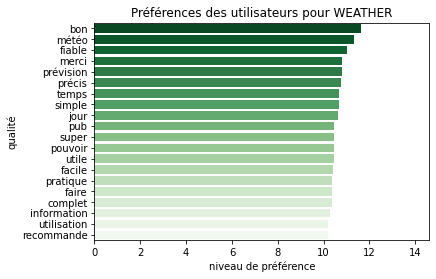

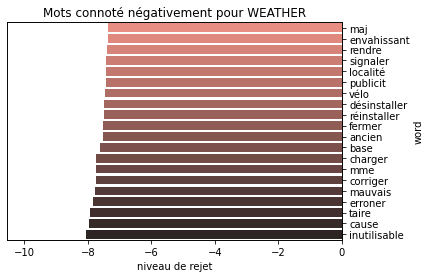

In [32]:
#AFFICHAGE DES RESULTATS

#On récupère les mots formant les colonnes de notre matrice TF_IDF, les coefficients associés à notre classe cible,
# on concatène ces deux séries puis on les trie par valeur des coefficients 
results = pd.concat([pd.Series(model['tfidf'].get_feature_names(), name='word'), pd.Series(model['clf'].coef_[-1], name='coeff')], axis=1).set_index('word').sort_values(by='coeff', ascending=False)
best_qualities = results.iloc[:20].reset_index()   #On récupère les 20 premières lignes (20 coefs les plus élevés)
worst_defaults = results.iloc[-20:].reset_index()  #On récupère les 20 dernières lignes (20 coefs les plus faibles)

#Pour visualiser les résultats, on va passer par des barplots : on crée des fonctions permettant de les tracer
def results_qual_bar(df, cat, scale=50):     #fonction permettant de tracer le barplot des qualités
    fig, ax = plt.subplots()
    df_copy = df.copy()
    df_copy['coeff'] = df_copy['coeff']+15    #pour avoir des valeurs positives, plus intuitif
    sns.barplot(x= df_copy['coeff'], y=df_copy['word'], palette='Greens_r')
    ax.set_xlim(right=scale)                  #avoir un axe des abscisses adapté
    ax.set_ylabel('qualité')
    ax.set_xlabel('niveau de préférence')
    titre = 'Préférences des utilisateurs pour '+cat
    ax.set_title(titre)
    plt.show()
    
def plot_defaults(df, categ, scale=-50):
    df_def_cop = df.copy()
    fig, ax = plt.subplots()
    ax.tick_params(                           #faire disparaitre les gradations de l'axe des ordonnées à gauche
        axis='y',          
        which='both',
        length = 0,      
        labelleft=False) 
    ax2= ax.twinx()                           #créer un axe des ordonnées à droite
    ax.set_xlim(left=scale, right=0)          #avoir un axe des absisses adapté
    ax.set_xlabel('niveau de rejet')
    ax2.set_ylabel('défaut')
    title = 'Mots connoté négativement pour '+categ
    plt.title(title)
    sns.barplot(x= df_def_cop['coeff'], y=df_def_cop['word'], palette='dark:salmon_r')
    plt.show()
    
scale = best_qualities['coeff'].iloc[0] + 18  #garder 3 de marge par rapport à la plus grande valeur pour les absisses
results_qual_bar(best_qualities, cat, scale)

scale = worst_defaults['coeff'].iloc[10]-3   #garder 3 de marge par rapport à la plus petite valeur pour les absisses
plot_defaults(worst_defaults, cat, scale)

Enfin, on enregistre nos résultats sous la forme de csv dans le dossier "Résultats"

In [78]:
#ENREGISTREMENT DES RESULTATS

file1 = 'Résultats/qualities_'+cat+'.csv'    #on crée le nombre du fichier contenant nos qualités pour cette categorie
best_qualities.set_index('word', inplace=True)
best_qualities.to_csv(file1)
file2 = 'Résultats/defaults_'+cat+'.csv'     #on crée le nombre du fichier contenant nos défaults pour cette categorie
worst_defaults.set_index('word', inplace=True)
worst_defaults.to_csv(file2)

**ANALYSE DES RESULTATS**

On va à présent comparer les différents résultats que l'on a pu obtenir pour les catégories sur lequelles on a déjà fait tourner le modèle. On va essayer d'identifier quels qualités ou défauts reviennent de manière récurrente ou au contraire quels mots sont spécifiques à une catégorie donnée. On va également chercher à visualiser des degrés de similarités entre les catégories analisées

<ins>Sélection des catégories à analyser et récupération des résultats<ins/>

L'utilisateur peut décider de conduire l'analyse sur l'ensemble des résultats disponibles : 

In [41]:
#SELECTION DE TOUS LES RESULTATS DISPONIBLES

results_to_explore = categ_list_done  #On crée une liste avec les noms de toutes les catégories déjà scrappées 

Ou il peut sélectionner uniquement les résultats qu'il souhaite analyser :

In [6]:
#OU CHOIX (MULTIPLE) DES RESULTATS A ANALYSER

#ouverture d'une boite de dialogue permettant la sélection des catégories souhaitées (cliquer dessus)
#Output : une liste avec les catégories sélectionnées par l'utilisateur
results_to_explore = selector('category', categ_list_done, multip_selec=True)   

Selon le choix de l'utilisateur, les qualités et défauts des catégories correspondantes sont récupéréées depuis le dossier "Résultats"

In [42]:
# RECUPERATION DES RESULTATS

list_of_qualities = [] #liste devant contenir des tuples (nom de la catégorie, qualités associées)
list_of_defaults = []  #liste devant contenir des tuples (nom de la catégorie, défauts associées)
for categ in results_to_explore:
    file_quali = 'Résultats/qualities_'+categ+'.csv'   #nom du fichier des qualités correspondant à la catégorie
    file_defaults = 'Résultats/defaults_'+categ+'.csv' #nom du fichier des défauts correspondant à la catégorie
    csv_quali = pd.read_csv(file_quali)                #On récupère le csv des qualités dans "Résultats"
    csv_defaults = pd.read_csv(file_defaults)          #On récupère le csv des défauts dans "Résultats"
    list_of_qualities += [(categ, csv_quali)]          #Ajout du tuple (nom de la catégorie, qualités associées)
    list_of_defaults += [(categ, csv_defaults)]        #Ajout du tuple (nom de la catégorie, défauts associées)

<ins>Visualisation des résultats pour chaque catégorie sélectionnée<ins/>

Pour chaque catégorie sélectionnée, on affiche le barplot des qualités et des défauts. 
La première cellule affiche les qualités, la grandeur associée est le coefficient (+15 pour avoir des données positives)

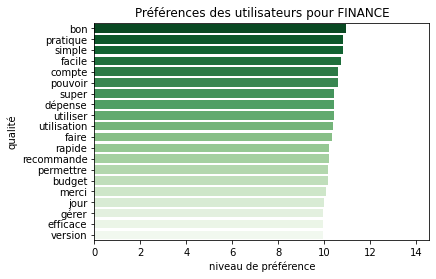

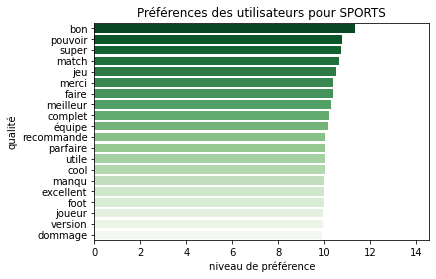

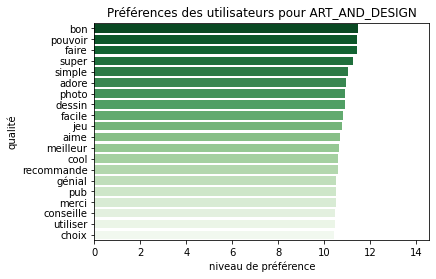

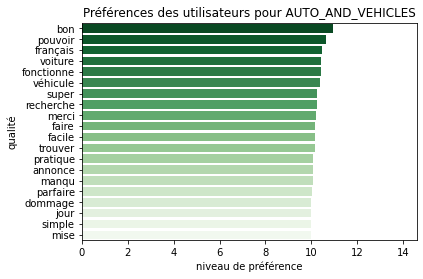

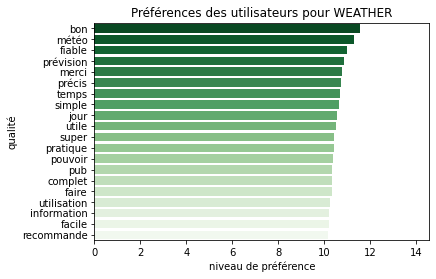

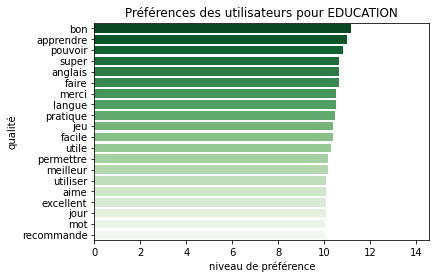

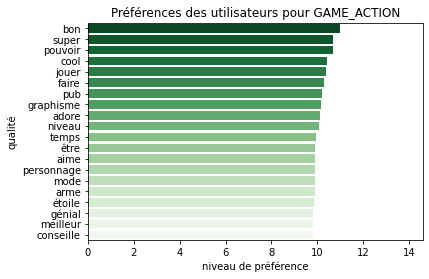

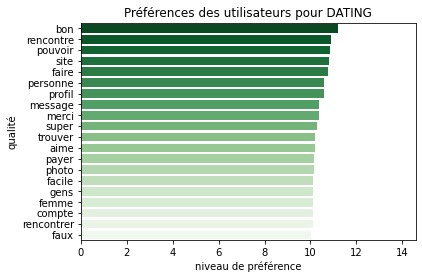

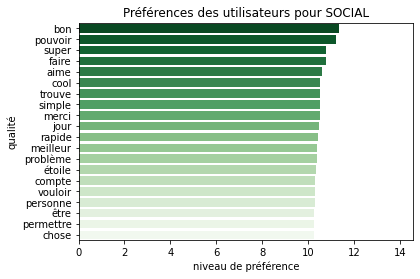

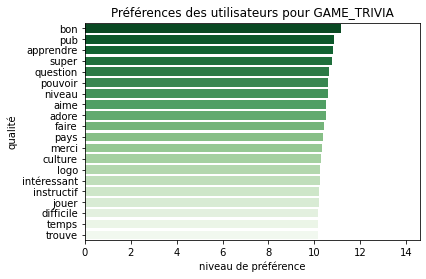

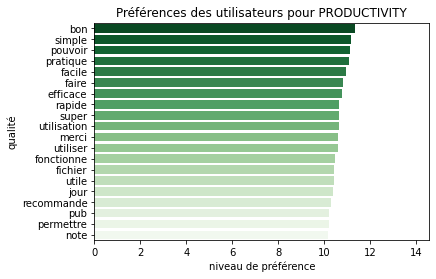

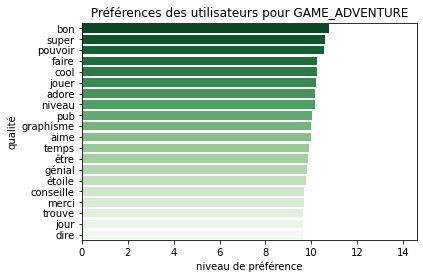

In [43]:
#BARPLOTS DES QUALITES POUR CHAQUE CATEGORIES

#On redéfinit les fonctions permettant de tracer les barplots, au cas où l'utilisateur n'aurait pas fait tourné la
#cellule dans laquelle elles étaient définies
def results_qual_bar(df, cat, scale=50):
    fig, ax = plt.subplots()
    df_copy = df.copy()
    df_copy['coeff'] = df_copy['coeff']+15
    sns.barplot(x= df_copy['coeff'], y=df_copy['word'], palette='Greens_r')
    ax.set_xlim(right=scale)
    ax.set_ylabel('qualité')
    ax.set_xlabel('niveau de préférence')
    titre = 'Préférences des utilisateurs pour '+cat
    ax.set_title(titre)
    plt.show()
    
def plot_defaults(df, categ, scale=-50):
    df_def_cop = df.copy()
    fig, ax = plt.subplots()
    ax.tick_params(
        axis='y',          
        which='both',
        length = 0,      
        labelleft=False) 
    ax2= ax.twinx()
    ax.set_xlim(left=scale, right=0)
    ax.set_xlabel('niveau de rejet')
    ax2.set_ylabel('défaut')
    title = 'Mots connoté négativement pour '+categ
    plt.title(title)
    sns.barplot(x= df_def_cop['coeff'], y=df_def_cop['word'], palette='dark:salmon_r')
    plt.show()


scale_base = max([list_of_qualities[k][1]['coeff'].iloc[0] for k in range(len(list_of_qualities))])+18
#On gardera la même échelle pour l'axe des absisses pour tous les plots, par soucis de comparabilité. On prend donc
#max avec trois de marge (+15 +3)

#Pour chaque catégorie, on fait tourner la fonction permettant de plot les qualités
for k in range(len(list_of_qualities)):
    df_quali = list_of_qualities[k][1]   #récupération du dataframe contenant les qualités
    name_cat = list_of_qualities[k][0]   #récupération du nom de la catégorie
    results_qual_bar(df_quali, name_cat, scale_base)

On identifie déjà des mots revenants de manière récurrentes. "bon" est à chaque fois en tête, souvent suivi de "pouvoir". Il semblerait donc que certaines qualités attendues soient communes à tous types d'applications et qu'autour de ces qualités générales s'ajoutent des catégories davantage spécifiques à une catégorie donnée. C'est ce que nous étudierons dans la prochaine partie (Analyse des mots par occurence)


Avant cela, affichons à présent les défauts pour chaque catégorie sélectionnée, la grandeur associée étant le coefficient

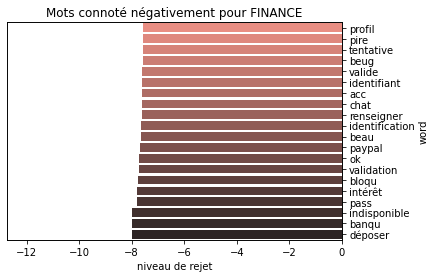

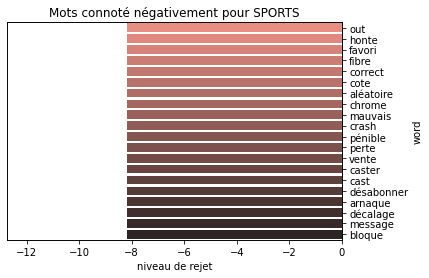

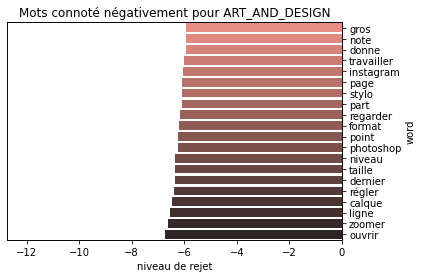

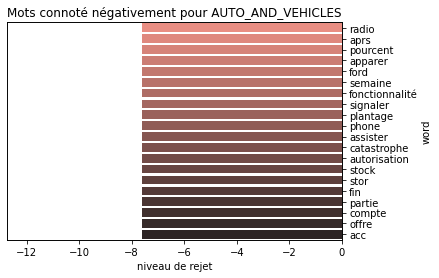

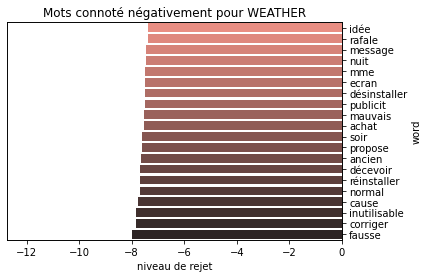

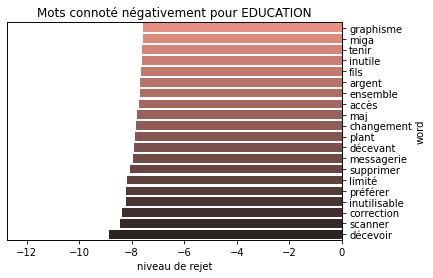

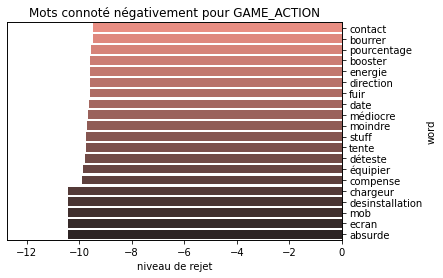

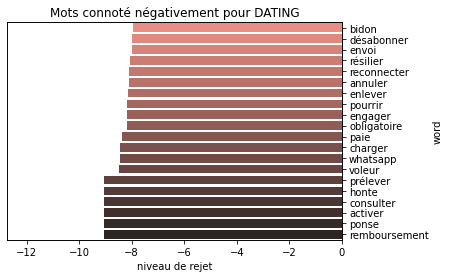

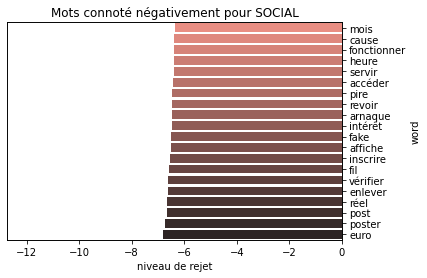

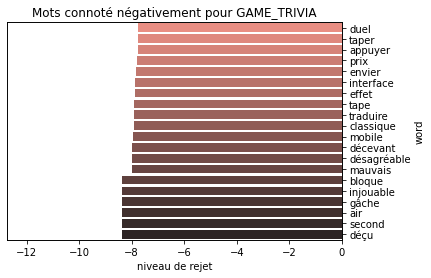

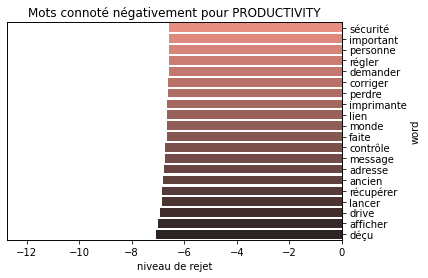

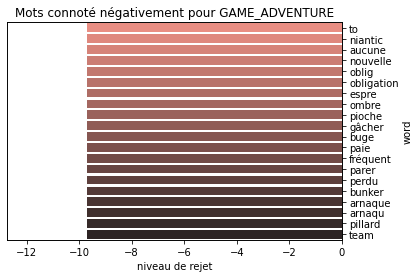

In [44]:
#L'échelle des abscisses sera identique pour chaque plot par soucis de comparabilité, on prend le min avec 3 de marge
scale_base = min([list_of_defaults[k][1]['coeff'].iloc[10] for k in range(len(list_of_defaults))])-3
for k in range(len(list_of_defaults)):
    df_def = list_of_defaults[k][1]      #récupération du dataframe contenant les défauts
    name_cat = list_of_defaults[k][0]    #récupération du nom de la catégorie
    plot_defaults(df_def, name_cat, scale_base)

Ici, les mots récurrents semblent en revanche plus difficiles à identifier. Il semble également y avoir plus de bruit (des mots que l'on n'associerait pas nécessairement à une connotation négative qui se retrouvent avec de faibles coefficients). Une explication à ce phénomène peut tenir dans le fait qu'un avis avec une note de 3/5 était identifié comme négatif. En faisant ce choix, nous augmentons la qualité de notre échantillon de "bons avis" (nécessairement des notes à 4/5 ou 5/5) mais dégradons celle de notre échantillon de "mauvais avis" en y intégrant les avis moyens. Par conséquent, notre modèle doit avant tout permettre d'identifier les qualités attendues par les utilisateurs, la partie sur les défauts étant nécessairement moins précise

<ins> Analyse des mots communs à plusieurs catégories </ins>

On va à présent regarder les mots (qualités ou défauts) revenant fréquemment. Cela va nous permettre d'identifier les qualités ou défauts "communs", ceux qui correspondent à des attentes générales des utilisateurs d'applications quel que soit le type d'application.

On commence par définir une fonction permettant d'identifier quels mots apparaissent dans plusieurs catégories et lesquels sont uniques

In [45]:
#CREATION D'OBJETS PERMETTANT D'ETUDIER LE NOMBRE D'OCCURENCE DES MOTS

#Cette fonction retourne un dataframe contenant les mots apparaissant plusieurs fois ainsi que leurs fréquence et une liste contenant les mots apparaissant
#une unique fois
def frequency_and_unique(df):
    df_0 = df[0][1].copy()                                    #On récupère le premier dataframe des qualités ou défauts (selon l'input)
    df_0.rename(columns={'coeff': df[0][0]}, inplace=True)    #Afin de ne pas perdre l'information du nom de la catégorie, on renomme la colonne des coeff

    for k in range(1,len(df)):                                #On fait de même pour toutes les autres catégories
        df_1 = df[k][1].copy()
        df_1.rename(columns={'coeff': df[k][0]}, inplace=True)
        full_word = pd.merge(df_0, df_1, on='word', how='outer')  #On merge le nouveau dataframe au précédent en s'appuyant sur les mots. Si un mot n'est
                                                                  # pas commun, on met NaN
        df_0 = full_word                                          #Le dataframe fusionné devient l'ancien dataframe df_0
                                                                  #output de cette boucle : full_word, df avec une colonne par catégorie et les coeffs associés

    full_word.set_index('word', inplace=True)                     #On redéfinit l'index, devient les mots

    sum_coef = full_word.sum(axis=1)                              #On somme les coefficients pour avoir une information globale sur ces coefficients
    info_word = pd.DataFrame(sum_coef, columns=['sum_coef'])      #On transforme la série contenant les mots en index et la somme des coeffs en un dataframe
    info_word['number of occurence'] = len(df) - full_word.isnull().sum(axis=1)   #On ajoute une colonne contenant le nombre d'occurence du mot
    list_of_unique = info_word[info_word['number of occurence']==1].index       #On crée une liste contenant les mots n'apparaissant qu'une fois

    df_multiple = info_word.loc[info_word['number of occurence']!=1].copy()     #On crée un dataframe ne contenant que les mots apparaissant plus d'une fois
    df_multiple['frequency'] = df_multiple['number of occurence']/len(df)*100   #On convertit le nombre d'occurence en fréquence d'apparition
    df_multiple = df_multiple.sort_values(by='frequency', ascending=False)      #On trie selon la fréquence
    
    return df_multiple, list_of_unique                                          #On récupère la liste des mots uniques et le df avec les mots multiples 

    
df_multiple_quali, list_of_unique_quali = frequency_and_unique(list_of_qualities)    #On récupère ces objets pour les qualités
df_multiple_defaults, list_of_unique_defaults = frequency_and_unique(list_of_defaults)  #On récupère ces objets pour les défauts

On représente les qualités et défauts par fréquence d'apparition, afin de voir lesquels apparaissent dans le plus de catégorie. On représente également les mots les plus importants en se basant sur le moyenne du coefficent du mot entre catégories (pour les mots apparaissant au moins deux fois)

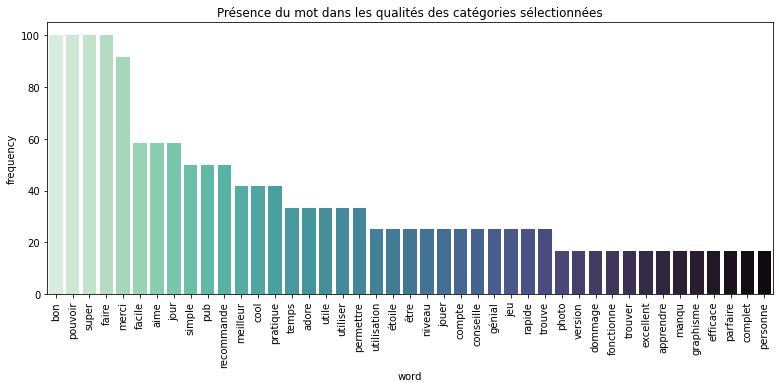

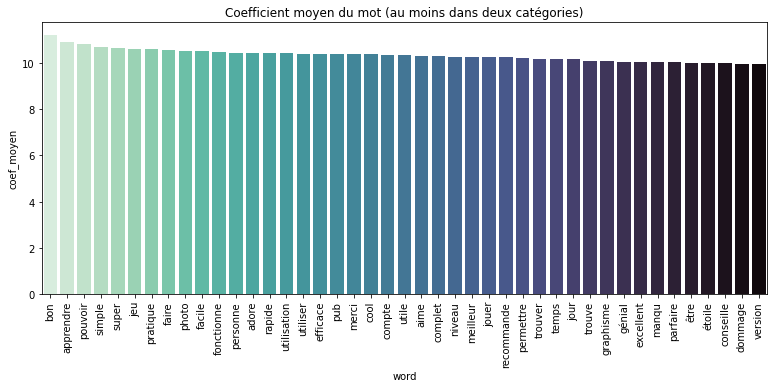

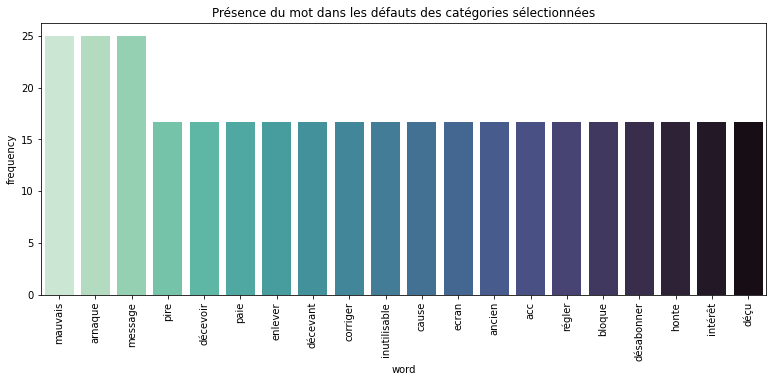

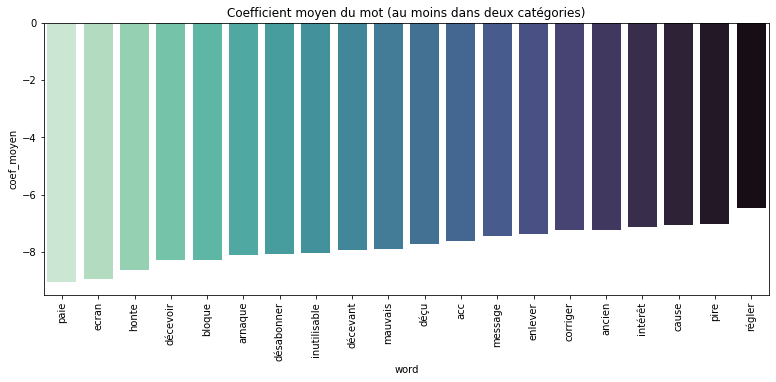

In [46]:
#REPRESENTATION DES MOTS LES PLUS FREQUENTS ET LES PLUS IMPORTANTS

#On crée une nouvelle colonne contenant la moyenne des coefficients pour les qualités
df_multiple_quali['coef_moyen'] = df_multiple_quali['sum_coef']/df_multiple_quali['number of occurence']+15   
df_multiple_quali_sortedcoef = df_multiple_quali.sort_values('coef_moyen', ascending=False)

#On crée une nouvelle colonne contenant la moyenne des coefficients pour les défauts
df_multiple_defaults['coef_moyen'] = df_multiple_defaults['sum_coef']/df_multiple_defaults['number of occurence']
df_multiple_defaults_sortedcoef = df_multiple_defaults.sort_values('coef_moyen', ascending=True)

#On réalise un barplot représentant la fréquence d'apparition des mots pour les qualités 
plt.figure(figsize=(13,5))                 #augmenter la largeur pour plus de visibilité
plt.xticks(rotation=90)                    #Avoir les mots écrits à la verticale pour plus de visibilité
plt.title('Présence du mot dans les qualités des catégories sélectionnées')
sns.barplot(x=df_multiple_quali.index, y=df_multiple_quali.frequency, palette='mako_r')
plt.show()

#On réalise un barplot représentant le coefficient moyen des mots apparaissant au moins deux fois pour les qualités
plt.figure(figsize=(13,5))
plt.xticks(rotation=90)
plt.title('Coefficient moyen du mot (au moins dans deux catégories)')
sns.barplot(x=df_multiple_quali_sortedcoef.index, y=df_multiple_quali_sortedcoef.coef_moyen, palette='mako_r')
plt.show()

#On représente un barplot représentant la fréquence d'apparition des mots pour les défauts 
plt.figure(figsize=(13,5))
plt.xticks(rotation=90)
plt.title('Présence du mot dans les défauts des catégories sélectionnées')
sns.barplot(x=df_multiple_defaults.index, y=df_multiple_defaults.frequency, palette='mako_r')
plt.show()

#On réalise un barplot représentant le coefficient moyen des mots apparaissant au moins deux fois pour les défauts
plt.figure(figsize=(13,5))
plt.xticks(rotation=90)
plt.title('Coefficient moyen du mot (au moins dans deux catégories)')
sns.barplot(x=df_multiple_defaults_sortedcoef.index, y=df_multiple_defaults_sortedcoef.coef_moyen, palette='mako_r')
plt.show()

En ce qui concerne les qualités, comme l'on pouvait s'y attendre, des termes positifs très généraux comme "bon", "super", "merci", "aime", "cool", "adore", etc. se retrouvent fréquemment dans nos résultats. Il semble en effet logique que ces mots soient souvent présents dans des commentaires associés à de bonnes notes, d'autant plus que comme on l'a vu ces avis sont souvent plus courts que la moyenne : lorsqu'ils sont satisfaits, plutôt que développer leurs avis, les utilisateurs se contentent de laisser des commentaires comme "bonne application", "cool", "j'adore" etc. A l'inverse, les fréquences d'apparition dans les résultats sont bien plus faibles en ce qui concerne les défauts : cela peut venir du problème du bruit, comme déjà évoqué, mais aussi du fait que les avis négatifs sont souvent davantage développés, davantage construits et utilisent donc des termes propres à la catégorie de l'application qu'ils critiquent. On retrouve tout de même quelques mots quelques termes généraux et connotés négativement comme "mauvais", "pire", "honte".
<br>

</br>
Au delà de ces termes vagues (bon, mauvais, etc.), logiquement présents mais qui ne nous apprennent pas grand chose, l'identification des autres termes fréquemment présents peut nous permettre d'en apprendre davantage sur les attentes générales et communes à tous les utilisateurs d'applications. Il est ainsi intéressant de noter que des termes comme <b>faire</b> ou <b>pouvoir</b> sont parmi les plus fréquents et parmi ceux qui possèdent le coefficient moyen le plus élevé. On retrouve également un peu plus loin le terme <b>permettre</b> En d'autres termes : si l'on <i> peut </i> <i> faire </i> X chose avec, si elle <i> permet </i> cela à l'utilisateur, alors elle sera bien notée. Pour cela il faut qu'elle <b> fonctionne </b> et soit <b> utile </b>, d'autres termes que l'on retrouve dans la liste des qualités fréquemment présentes et qui possèdent un coefficient relativement élevé.
On remarque également la fréquence importante de mots du champ lexical de la simplicité : <b>simple</b>, <b>facile</b>. L'alliance de la <i> simplicité </i> et de <i> l'utilité </i> rend l'application <b>efficace</b> et <b>pratique</b>, d'autant plus si elle est <b>rapide</b>, deux autres termes que l'on retrouve.

On retrouve également dans les qualités quelques mots auxquels on associe habituellement une connotation négative, comme "parfaire", "dommage" et "manque". Il se peut que cela vienne d'avis d'utilisateurs satisfaits mais qui jugent que l'application auraient pu être meilleure sur certains poins : c'est une bonne application mais il est <i> dommage </i> qu'il <i>manque </i> cela, on peut la <i> parfaire </i>. On note d'ailleurs que ces mots sont parmi les mots classés comme qualités qui possèdent le plus faible coefficient.
<br>
</br>
Au niveau des défauts, on retrouve des termes évoquant la tromperie : <b> arnaque </b>, <b> décevoir </b>, <b> déçu </b>. Autrement dit, si l'application une fois téléchargée ne tient pas les promesses de sa page Google Play, elle aura une mauvaise note. De plus, les applications demandant à l'utilisateur qu'il <b> paie </b> sont très mal notée : c'est le coefficient le plus négatif. On retrouve également le terme <b> désabonner </b>, faisant références à des applications <i> payantes </i> et en plus <i>décevantes</i>. Enfin, plusieurs mots font référence au mauvais fonctionnement : <b> corriger </b>, <b> inutilisable </b>, <b> régler </b>, <b> bloque </b>. Logiquement, une application fonctionnant mal sera mal notée
<br>
</br>
Cette étude des mots les plus fréquents nous permet ainsi de déterminer les attentes communes des utilisateurs d'applications, quelle que soit leurs catégories : ils veulent une application utile, facile d'utilisation, rapide et qui fonctionne sans accroc. A l'inverse, ils mettront une mauvaise note s'ils s'estiment trompés (si l'application ne tient pas ses promesses), si l'application leur demande de payer ou si elle fonctionne mal.



<ins> Similarités entre catégories </ins>

Identifions, sur la base de ces qualités et défauts partagés par plusieurs catégories, quelles catégories d'applications sont les plus proches en terme d'attentes des consommateurs. Pour cela, nous allons construire une matrice d'adjacence reposant sur le nombre de qualités/défauts communs entre deux catégories. Puis nous représenterons celle-ci sous la forme d'un graphe. La position des catégories nous permet d'identifier des clusters de catégories pour lesquelles les attentes des consommateurs sont proches. Plus l'arrête reliant deux noeuds est foncée, plus ces noeuds partage de qualités et défauts en commun.

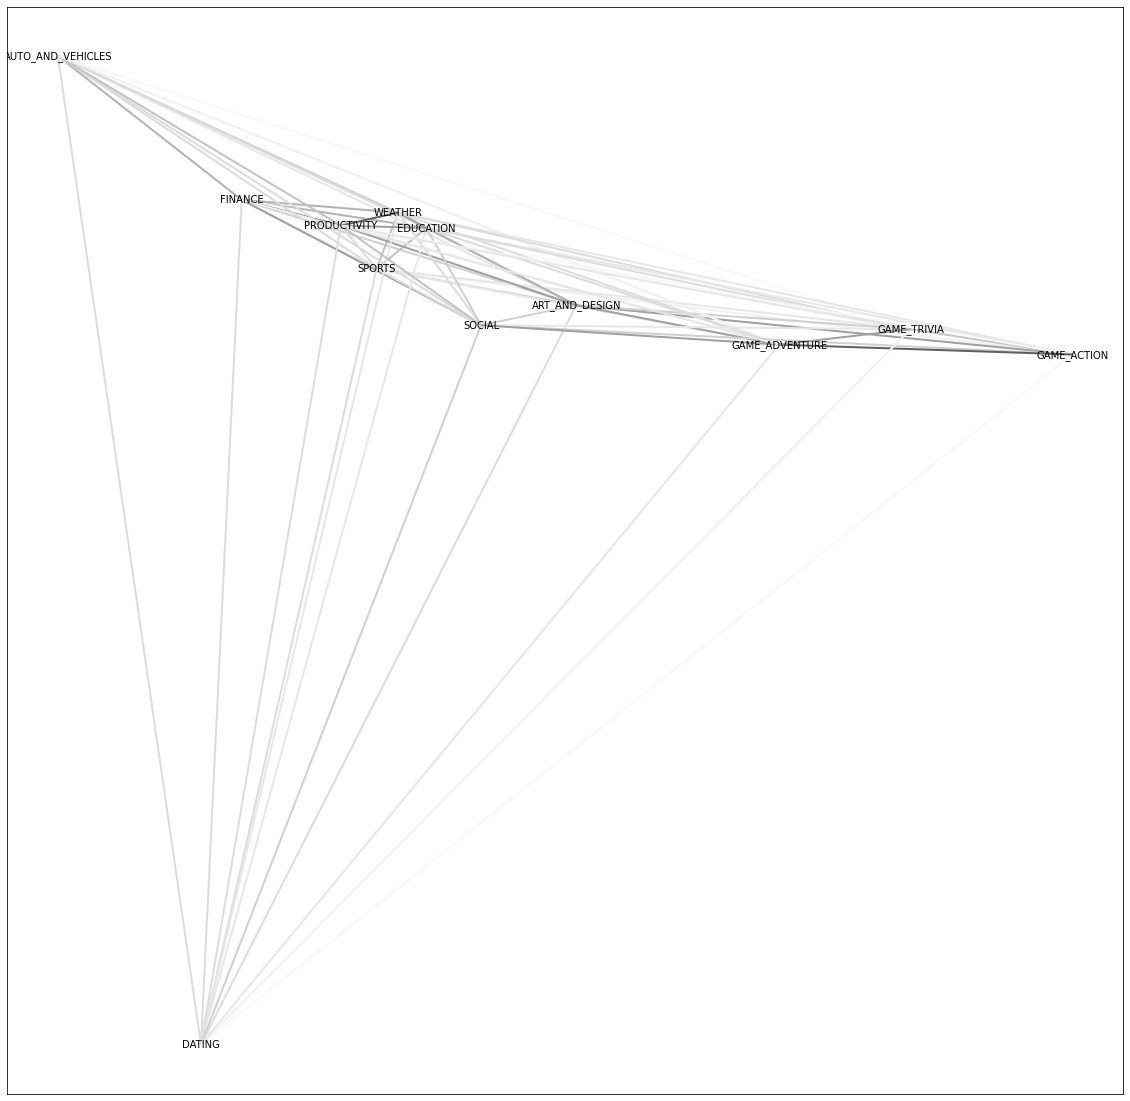

In [47]:
import networkx as nx
from networkx import convert_matrix as cm

dict_label = {}                                                            #On va créer un dictionnaire attribuant une clé au noms de nos catégories
adjacency = np.zeros((len(list_of_qualities),len(list_of_qualities)))      #On crée une matrice nulle carrée de dimension notre nombre de catégorie
for i in range(len(list_of_qualities)):
    qualities_i = list_of_qualities[i][1]                                  #On récupère les qualités de la i-eme catégorie
    defaults_i = list_of_defaults[i][1]                                    #On récupère les défauts de la i-eme catégorie
    word_i = set(pd.concat([qualities_i, defaults_i])['word'])             #On crée un set contenant l'ensemble des qualités et défauts de la catégorie i
    dict_label[i] = list_of_qualities[i][0]                                #On attribue à notre catégorie la clé i dans le dictionnaire
    for j in range(len(list_of_qualities)):                                
        qualities_j = list_of_qualities[j][1]                              #On récupère les qualités de la j-eme catégorie
        defaults_j = list_of_defaults[j][1]                                #On récupère les défauts de la j-eme catégorie
        word_j = set(pd.concat([qualities_j, defaults_j])['word'])         #On crée un set contenant l'ensemble des qualités et défauts de la catégorie j
        common_word = word_i.intersection(word_j)                          #On récupère uniquement les mots communs aux deux sets
        frac = len(common_word)/len(word_i)                                #On calcule la proportion de mots communs
        adjacency[i,j] = frac                                              #On assigne cette proportion à la valeur (i,j) de la matrice d'adjacence

network = cm.from_numpy_matrix(adjacency)                                  #On crée un graphe à partir de la matrice d'adjacence
edges,weights = zip(*nx.get_edge_attributes(network,'weight').items())     #On récupère les noeuds et poids du graphe

plt.figure(figsize=(20,20))                                                #On augmente la taille de la figure en output pour faciliter la lecture

pos = nx.spectral_layout(network)                                          #On détermine la position des points selon la méthode spectrale pour créer des clusters par degré de similarité 
nx.draw_networkx_nodes(network, pos=pos, node_color='grey', alpha=0)       #On affiche les noeuds (nécessaire pour avoir une visualisation de bonne échelle) mais on les fait disparaitre en maximisant la transparence
nx.draw_networkx_labels(network, pos=pos, labels=dict_label, font_size=10, verticalalignment='center', alpha=1) #On  affiche les noms des catégories au niveau des noeuds
nx.draw_networkx_edges(network, pos, width=2, edge_color=weights, edge_cmap=plt.cm.Greys, edge_vmax=0.53) #On affiche les arrêtes, plus elles sont grises plus la similarité est élevée
plt.show() 

On identifie un premier cluster composé des différents jeux (action, aventure, quizz), avec notamment un fort lien entre game_action et game_adventure.  Un deuxième cluster est composé des applications de finance, sports (paris etc.), productivité, météo et éducation : ce sont sans doute des applications dont on attend de l'efficacité, de la précision, de l'information. Social et Art et design pourraient donner l'impression trompeuse de former un cluster, mais on voit que l'arrête les liant est très claire : ces deux catégories sont en fait liées aux deux premiers clusters sans appartenir à aucun d'entre eux et se trouvent donc toutes deux à mi-chemin. Auto et véhicules ainis que Dating sont isolés, mais le lien le plus fort de Dating est logiquement avec social. Dans l'ensemble, nos clusters paraissent donc cohérents

<ins> Etude des attentes propres à une catégorie donnée </ins>

Enfin, rentrons désormais davantage dans le détail des attentes propres à chaque catégorie. Pour cela, on s'intéresse aux mots apparaissant une unique fois. On les représente pour chaque catégorie par le moyen d'un workcloud, la taille étant déterminée par le coefficient associée au mot (et donc par son niveau d'importance)

SPECIFIC QUALITIES :
FINANCE


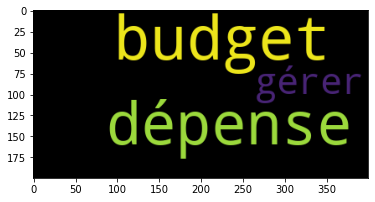

SPORTS


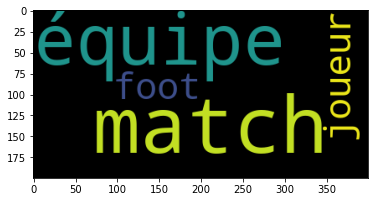

ART_AND_DESIGN


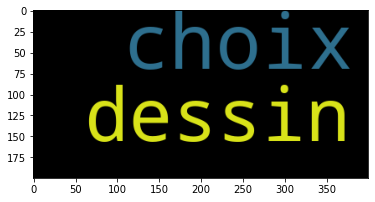

AUTO_AND_VEHICLES


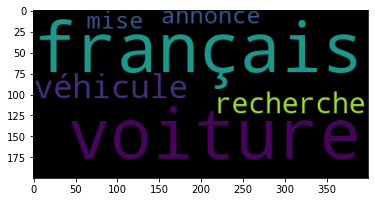

WEATHER


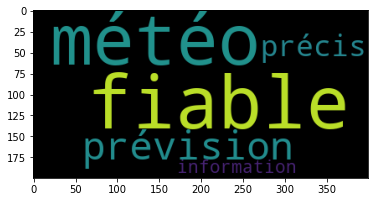

EDUCATION


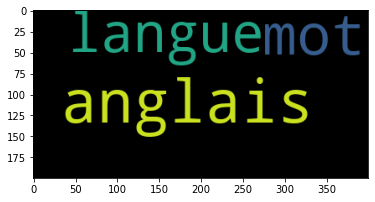

GAME_ACTION


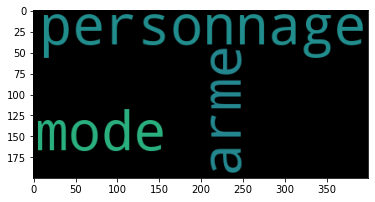

DATING


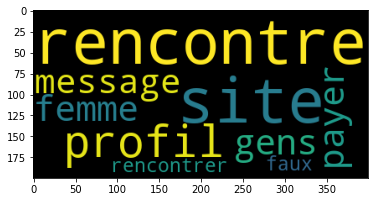

SOCIAL


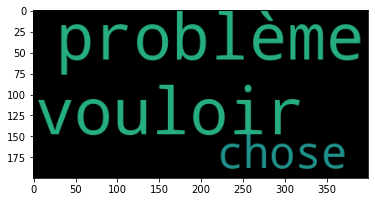

GAME_TRIVIA


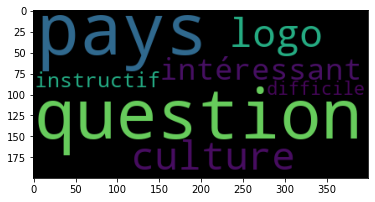

PRODUCTIVITY


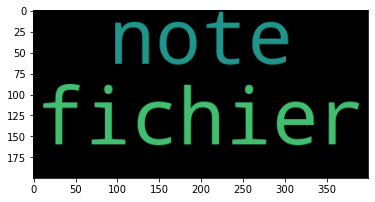

GAME_ADVENTURE


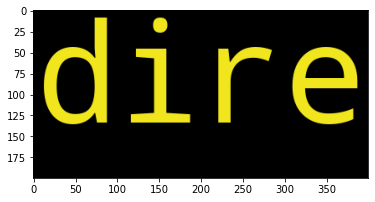



SPECIFIC DEFAULTS :
FINANCE


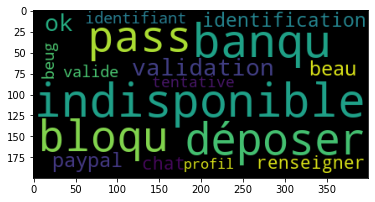

SPORTS


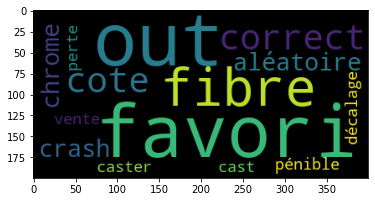

ART_AND_DESIGN


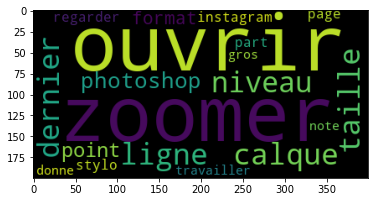

AUTO_AND_VEHICLES


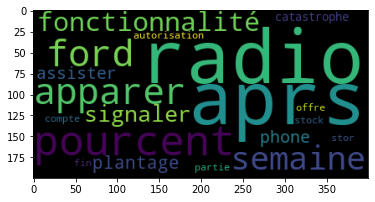

WEATHER


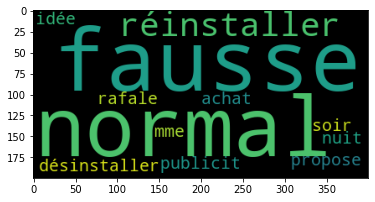

EDUCATION


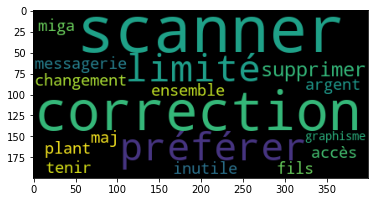

GAME_ACTION


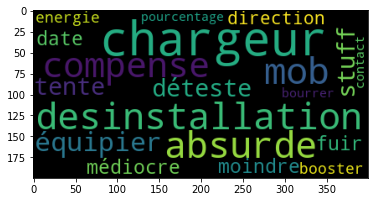

DATING


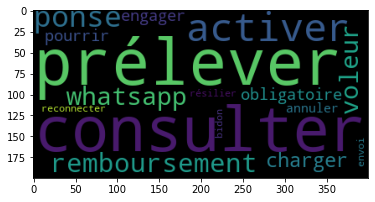

SOCIAL


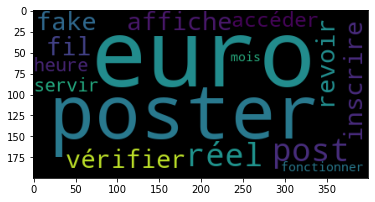

GAME_TRIVIA


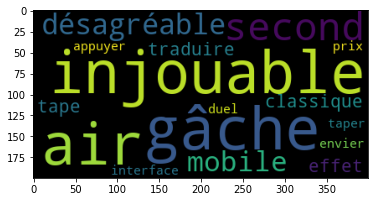

PRODUCTIVITY


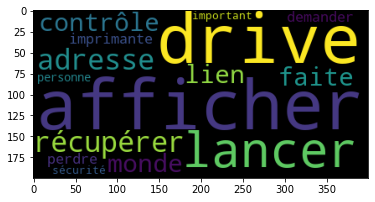

GAME_ADVENTURE


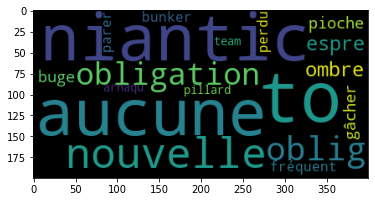

In [48]:
from wordcloud import WordCloud


def cloud_unique(df, unique, reverse=False):
    for k in range(len(df)):
        df_k = df[k][1].copy()                            #On récupère le dataframe avec les résultats
        df_k = df_k.loc[df_k['word'].isin(unique)]        #On ne conserve que les lignes correspondants à des mots n'apparaissant que pour cette catégorie
        print(df[k][0])                                   #On affiche le nom de la catégorie
        if reverse == False:                              #Si plus le coefficient est grand plus le mot est important (cas des qualités)
            dict_unique = df_k.set_index('word')['coeff'].to_dict()  #On crée un dictionnaire avec les mots en clé et le coefficient associé en valeur
        else:                                             #Si plus le coefficient est petit plus le mot est important (cas des défauts)
            dict_unique = (-df_k.set_index('word')['coeff']).to_dict() #On crée un dictionnaire avec les mots en clé et l'opposé du coefficient associé en valeur
        wc = WordCloud()                                  
        wc.generate_from_frequencies(dict_unique)         #On crée le wordcloud depuis notre dictionnaire
        plt.imshow(wc)                                    #On affiche le dictionnaire
        plt.show()

#On fait tourner la fonction pour les qualités
print('SPECIFIC QUALITIES :')
cloud_unique(list_of_qualities, list_of_unique_quali)
print('\n')

#On fait tourner la fonction pour les défauts
print('SPECIFIC DEFAULTS :')
cloud_unique(list_of_defaults, list_of_unique_defaults, True)

Pour les raisons déjà évoquées, les worclouds des défauts présente davantage de mots mais aussi davantage de bruit. A l'inverse, il arrive parfois que les workclouds des qualités apparaissent assez vides : les qualités que l'on a pu récupérer sont communes à d'autres catégories et n'apparaissent donc pas ici. Autre limite : certains mots sont des synonymes de qualités/défauts déjà identifiés dans la partie précédente (notamment en ce qui concerne les défauts de fonctionnement ou les applications payantes: "indisponnible", "injouable", "réinstaller", "achat", "premium", "planter", "argent"...). Enfin, à l'inverse certains termes communs à des catégories proches mais qui leur sont spécifiques n'apparaitront pas (cf game action et game_adventure). Il est néanmoins possible de tirer quelques conclusions intéressantes :
<ul>
    <li>Les applications de la catégorie Finance les plus valorisées semblent être celles qui permettent la gestion des dépenses et de son budget. Les utilisateurs bloqués par leur banque ou qui ont des problèmes d'identification mettront une mauvaise note.</li>
    <li>Les applications de sport les plus valorisées sont celles portant sur le foot. Les termes liés aux application de paris ("favori", "cote") se retrouvent dans les défauts car ils peuvent être associés à des pertes.</li>
    <li>Les applicatiosn de la catégorie Art et Design qui semblent les plus valorisés sont les applications de dessin. Les défauts portent sur des termes non nécessairement connotés négativement mais il se peut que cela fasse référence à des défauts de fonctionnement portant sur ces termes (impossible de zoomer, d'ouvrir etc) </li>
    <li> Les applicatiosn de la catégorie Auto et véhicule qui semblent les plus valorisés sont celles permettant de poster/rechercher des annonces. Les défauts semblent comporter beaucoup de bruits. Il faut noter que c'était la plus petite base (scrappées sans Sélenium), ce qui peut être en cause.</li>
    <li> Les applications météo doivent être fiables et précises dans leurs prévisions, donner de l'informations. Elles seront mal notées si les prévisions sont fausses ou s'il y a de la pub</li>
    <li>Les applications d'éducation les plus valorisées semblent être celles qui permettent d'apprendre une langue, notamment l'anglais. Elles seront mal notées si elles sont jugées inutiles ou si leur contenu nécessite des corrections</li>
    <li> En ce qui concerne les jeux d'actions, les graphismes étaient particulièrement valorisés mais cela n'apparait plus car c'est une qualité commune aux jeux d'aventure. Les jeux de guerres (avec des armes) semblent préférés, sauf si le chargeur possède des défauts. Le jeux sera mal noté si certains éléments paraissent absurdes.</li>
    <li> Les applications de dating seront bien notés si elles permettent de réaliser des rencontres. Elles seront mal notés s'il y a un caractère obligatoire, qui engage (dans le paiement probablement : cf le mot prélèvement et le mot voleur).</li>
    <li> Difficile de tirer des conclusions depuis la catégorie Social </li>
    <li> Les jeux trivia seront bien notés s'ils sont instructifs, intéressant, augmentent la culture.</li>
    <li> Les applications productivité les mieux notées semblent être celles permettant d'écrire des notes ou de stocker des fichiers. Elles seront mal notées si elles provoquent des pertes qu'il faudra récupérer ou ont des problème de sécurité </li>
    <li> Pour les jeux d'aventure, le plus important est là encore les graphismes mais cela n'apparait pas car c'est commun avec les jeux d'action</li>
    
 

**CONCLUSION**

Du fait de nos choix concernant la classification, notre modèle est davantage fiable concernant l'identification des qualités attendues que des défauts à éviter, même  s'il nous donne des informations intéressantes concernant cette seconde catégorie également. Dans l'ensemble, il semblerait que les utilisateurs partagent des attentes communes quel que soit la catégorie de l'application : une application utile, simple à utiliser, rapide, efficace, pratique et sans défauts de fonctionnement. Ils sanctionneront les applications trompeuses, qui les ont déçus dans leurs attentes, payantes et qui possèdent des bugs.
<br>
</br>
Naturellement, il ne s'agit ici que d'un portrait robot de l'application idéale et ces attentes globalement partagées ne sont pas nécessairement communes à l'intégralité des catégories : elles devraient plus ou moins l'être en revanche au sein des clusters que l'on a pu identifier grâce au graphe ci-dessus.
<br>
</br>
Enfin, si l'on réduit encore l'échelle, on peut identifier les attentes propres à une catégorie donnée. On voit ainsi que ce qui compte le plus pour les applications météo est la qualité des prévisions et la fiabilité, pour les jeux trivia ce sera le caractère instructif et intéressant, que les pertes de données et les failles de sécurités seront sanctionnés dans les applications de la catégorie productivité...